In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from h5py import File
import os
import csv

RGBs = ['r', 'g', 'b']

In [2]:
from ImgProcess import Show     # import all functions from ../Codes/ImgProcessing.py
from KSVD import Learn              # import all functions from ../Codes/KSVD.py
from ResultTest import PSNR

In [3]:
# read the gray scale images
imgList_gray = [file[: -4] for file in os.listdir('../Images/') if file.endswith('.png')]
imgList_rgb = [file[: -4] for file in os.listdir('../Images/McM images/') if file.endswith('.tif')]

# Task 1. 灰色图像的字典学习算法

使用 K-SVD 算法对灰度图像进行字典学习. 

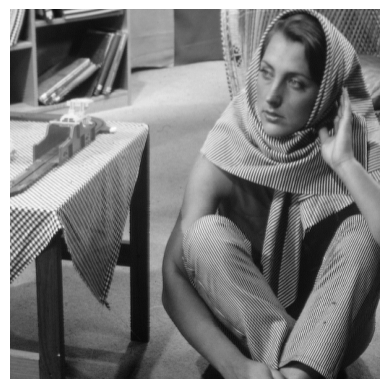

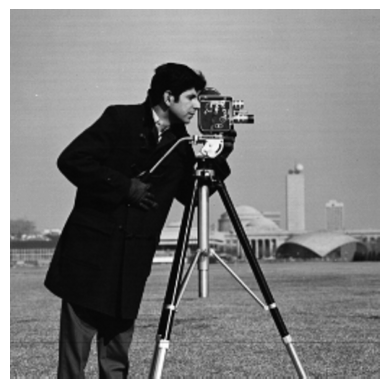

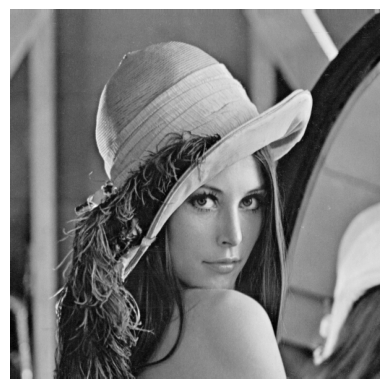

In [66]:
for fileName in imgList_gray:
    img = plt.imread('../Images/' + fileName + '.png')

    size = 72

    img_learned, mD = Learn(img, size, 16, 12)
    # print(PSNR(img, img_learned))

    path_dict = '../results/dictionaries/' + fileName + '.csv'
    with open(path_dict, 'w', newline='') as f_dict:
        writer = csv.writer(f_dict)
        writer.writerow([fileName, f' patch size = {size}'])
        writer.writerows(mD)
        writer.writerow([''])
    
    Show(img_learned)

# Task 2&3. 彩色图像的字典学习算法与降噪

In [64]:
with open('../results/PSNR.csv', 'w', newline='') as f_psnr:
    writer = csv.writer(f_psnr)
    writer.writerow(['image', 'r', 'g', 'b', 'rgb'])

In [65]:
for fileName in imgList_rgb:
    # load the image
    img_clear = plt.imread('../Images/McM images/' + fileName + '.tif') / 255
    img_noisy = File('../Images/McM images/' + fileName + '_noise.mat')
    img_noisy = [_.T for _ in img_noisy['u_n']]

    size = 72

    # save the learned dictionary
    path_dict = '../results/dictionaries/' + fileName + '.csv'
    with open(path_dict, 'w', newline='') as f_dict:
        writer = csv.writer(f_dict)
        writer.writerow([fileName, f' patch size = {size}']) # write the image name and patch size

    # learn the dictionary for each channel
    # img_learned = []
    dicts = {}
    img_denoised = []
    psnr = {}

    for i, color in enumerate(RGBs):
        # extract the channel
        channel = img_clear[:, :, i]

        # learn the dictionary
        channel_learned, mD = Learn(channel, size, 16, 12)

        # print(PSNR(channel, channel_learned))

        dicts[color] = mD   # record the learned dictionary
        # img_learned.append(channel_learned)
        
        with open(path_dict, 'a', newline='') as f_dict:
            writer = csv.writer(f_dict)
            writer.writerow(['channel:' + color])           # write the channel name
            writer.writerows(dicts[color])                  # write the dictionary
            writer.writerow([''])

        # denoise the image using the learned dictionary
        # extract the channel
        mD = dicts[color]
        channel_noise = img_noisy[i]

        # denoise the channel: use max_iter=1 only learning once for the sparse coding
        channel_denoised, _ = Learn(channel_noise, size, 4, max_iter=1, mD=mD)
        # normalize the channel
        channel_denoised = (channel_denoised - channel_denoised.min()) / (channel_denoised.max() - channel_denoised.min())
        # calculate the PSNR value
        psnr[color] = PSNR(channel, channel_denoised)
        img_denoised.append(channel_denoised)

    img_denoised = np.stack(img_denoised, axis=2)
    # save the denoised image
    path_img = '../results/images denoised/' + fileName + '.png'
    plt.imsave(path_img, img_denoised)
    
    # write the PSNR value to the csv file
    psnr['rgb'] = (psnr['r'] + psnr['g'] + psnr['b']) / 3
    with open('../results/PSNR.csv', 'a', newline='') as f_psnr:
        writer = csv.writer(f_psnr)
        writer.writerow([fileName, psnr['r'], psnr['g'], psnr['b'], psnr['rgb']])